In [52]:
from ipynb.fs.full.Introduction import *
from tqdm import tqdm
import time

## Dataset

In [93]:
train = torch_geometric.datasets.ZINC('.',subset=True)
test = torch_geometric.datasets.ZINC('.',subset=True)

train_list = []
for idx in range(len(train)):
    D = train[idx]
    D.x = D.x.float()
    D.edge_weight = D.edge_attr/torch.sum(D.edge_attr.abs())
    
    train_list.append(D)
    
test_list = []
for idx in range(len(test)):
    D = test[idx]
    D.edge_weight = D.edge_attr/torch.sum(D.edge_attr.abs())
    D.x = D.x.float()

    test_list.append(D)

train_loader,test_loader = torch_geometric.data.DataLoader(train_list,batch_size=200,shuffle=True),\
                                      torch_geometric.data.DataLoader(test_list,batch_size=200,shuffle=True)

## Model

In [94]:
class DummyModel(torch.nn.Module):
    def __init__(self,in_channels,int_channels,out_channels,depth):
        super(DummyModel,self).__init__()
        self.start = torch.nn.Linear(in_channels,int_channels)
        self.intermediate = torch.nn.ModuleList([torch.nn.ModuleList([torch.nn.Linear(int_channels,int_channels),\
                                                                      torch.nn.Linear(int_channels,int_channels)])\
                                                 for _ in range(depth)])
        self.finish = torch.nn.Sequential(*[torch.nn.Linear(2*int_channels,int_channels),torch.nn.LeakyReLU(),
                                            torch.nn.Linear(int_channels,int_channels),torch.nn.LeakyReLU(),
                                            torch.nn.Linear(int_channels,out_channels)])
        self.norm = torch.nn.ModuleList([torch.nn.BatchNorm1d(int_channels) for _ in range(depth)])

    def forward(self,X,edge_index,edge_weight,batch):
        X = self.start(X)
        for idx,m in enumerate(self.intermediate):
            Update = m[0](X) + torch_scatter.scatter_sum(edge_weight[:,None] * m[1](X)[edge_index[1]], edge_index[0],dim=0)
            X = torch.nn.LeakyReLU()(self.norm[idx](X))
            
            if torch.isnan(X).any(): raise ValueError
        mu = torch_scatter.scatter_mean(X,batch,dim=0)
        var = torch_scatter.scatter_mean((X - mu[batch])**2,batch,dim=0)
        
        return self.finish(torch.cat((mu,var),dim=1))

In [95]:
def RMSE(X,Y,batch):
    return torch.sqrt(torch.mean(X**2 + Y**2 - 2*X*Y))

def MAE(X,Y,batch):
    return torch.nn.L1Loss()(X,Y)

## Training -- BatchNorm

In [97]:
metrics = []
torch.manual_seed(0)

for k in [1,2,4,8,16,32,64]:
    model = DummyModel(data_list[0].x.shape[-1],32,data_list[0].y.shape[-1],k).cuda()
    metrics.append(train_loop(model,train_loader,test_loader,150,lr=1e-2,
                             metric_func = RMSE, loss_func = MAE))
    torch.cuda.empty_cache()

ValueError: 

In [98]:
k

64

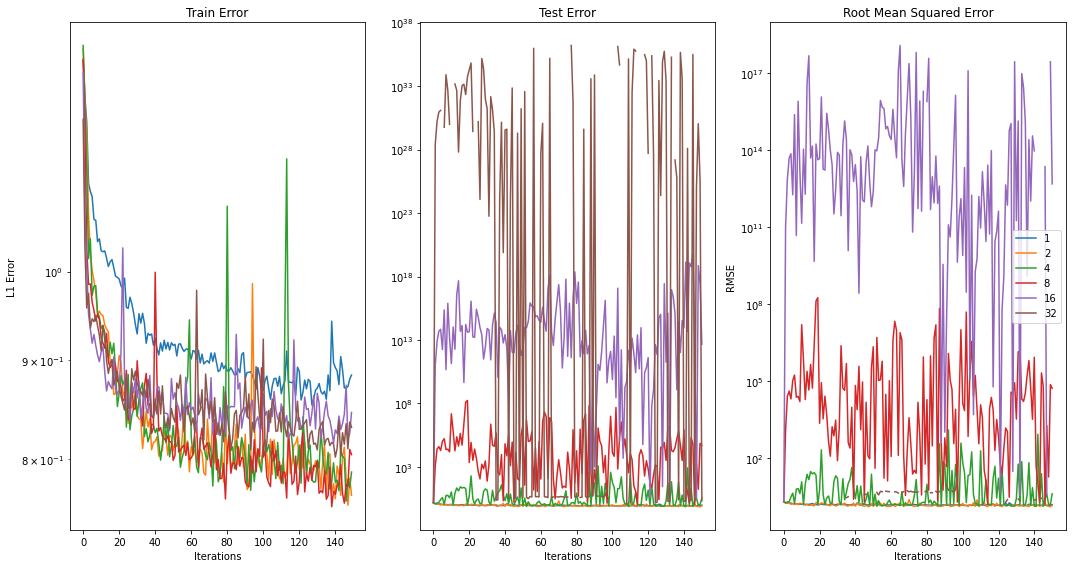

In [99]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for i in range(6):
  plt.semilogy(metrics[i][0])

plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for i in range(6):
  plt.semilogy(metrics[i][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,alpha in enumerate([1,2,4,8,16,32]):
  plt.semilogy(metrics[idx][2],label=alpha)
plt.title('Root Mean Squared Error')
plt.ylabel('RMSE')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

## Training -- Norm

In [46]:
class DummyModel(torch.nn.Module):
    def __init__(self,in_channels,int_channels,out_channels,depth):
        super(DummyModel,self).__init__()
        self.start = torch.nn.Linear(in_channels,int_channels)
        self.intermediate = torch.nn.ModuleList([torch.nn.ModuleList([torch.nn.Linear(int_channels,int_channels),\
                                                                      torch.nn.Linear(int_channels,int_channels)])\
                                                 for _ in range(depth)])
        self.finish = torch.nn.Sequential(*[torch.nn.Linear(2*int_channels,int_channels),torch.nn.LeakyReLU(),
                                            torch.nn.Linear(int_channels,int_channels),torch.nn.LeakyReLU(),
                                            torch.nn.Linear(int_channels,out_channels)])

    def forward(self,X,edge_index,edge_weight,batch):
        X = self.start(X)
        for idx,m in enumerate(self.intermediate):
            Update = m[0](X) + torch_scatter.scatter_sum(edge_weight[:,None] * m[1](X)[edge_index[1]], edge_index[0],dim=0)
            X = torch.nn.LeakyReLU()(X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch])
            
            if torch.isnan(X).any(): raise ValueError
        mu = torch_scatter.scatter_mean(X,batch,dim=0)
        var = torch_scatter.scatter_mean((X - mu[batch])**2,batch,dim=0)
        
        return torch.sigmoid(self.finish(torch.cat((mu,var),dim=1)))

In [47]:
metrics = []
torch.manual_seed(0)

for k in [1,2,4,8,16]:
    model = DummyModel(data_list[0].x.shape[-1],32,data_list[0].y.shape[-1],k).cuda()
    metrics.append(train_loop(model,train_loader,test_loader,150,lr=1e-2,
                             metric_func = RMSE, loss_func = MAE))
    torch.cuda.empty_cache()

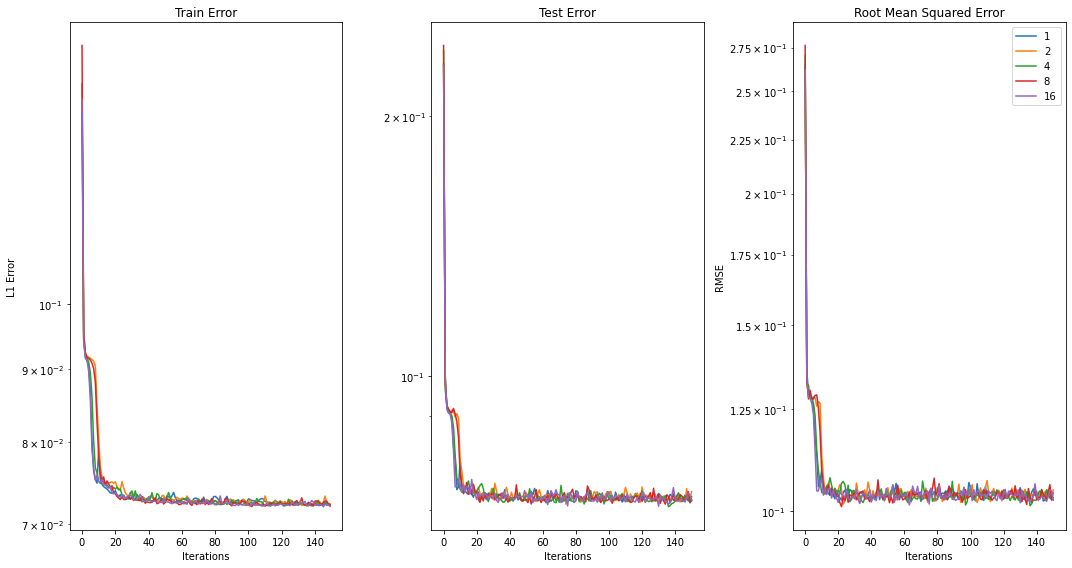

In [48]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for i in range(5):
  plt.semilogy(metrics[i][0])

plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for i in range(5):
  plt.semilogy(metrics[i][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,alpha in enumerate([1,2,4,8,16]):
  plt.semilogy(metrics[idx][2],label=alpha)
plt.title('Root Mean Squared Error')
plt.ylabel('RMSE')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

In [51]:
data[3].y

tensor([[-410.2862,   15.9738,    2.2285,  -10.7060,    2.1450,    4.6241,
           10.4658,   -1.8985,   -8.4021,    0.4143,  -11.1629,    1.1958,
            3.5124,    3.3217]])